# Prediction of the isotopic inventory in a nuclear reactor core

*Benjamin Dechenaux & Jean-Baptiste Clavel (IRSN, PSN-RES/SNC/LN)*

## Introduction 

Matter contained inside a nuclear reactor undergoes irradiation that causes successive cascades of nuclear reactions, modifying its atomic composition. Knowledge of this time evolving composition is an important parameter used to model the behavior of a nuclear reactor but is also a crucial input for safety studies associated with its operation and is a key input for the mitigation of severe accident for it constitute, for instance the source term of the release of radioactive isotopes in the environment. 

The modelling of the change in the atomic composition of irradiated materials over time is usually achieved using time expensive Monte Carlo simulation of the system beign studied. Although precise, this calculation scheme has been found inadapted in crisis (i.e. accidental) situations, where faster calculation schemes have to be developped. 

This project aims at constructing a surrogate model capable at predicting the time changing nuclear inventory of a typical reactor of the French fleet. 

## Requirements for running the notebook 

To properly run the notebook, the following Python modules must be imported :

In [1]:
# Required for running the notebook 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import pickle
import string

# Keras dependences for the baseline Neural Network
from keras import models
from keras import layers
from keras.optimizers import Adagrad


%matplotlib inline

Using TensorFlow backend.
/soft/anaconda3/5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/soft/anaconda3/5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/soft/anaconda3/5.1.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/soft/anaconda3/5.1.0/lib/python3.6/site-packages/tensorflo

## Description of the data 

The atomic composition of the material subjected to irradiation usually involves thousands of isotopes. However, most of them have short lifetimes (characteristic decay time) and are not of critical interest for the safety of the facility or the mitigation of a reactor accident. 

In this project, we propose to track the temporal evolution of __26 isotopes__ that have a significant impact on the reactor behaviour or are isotopes whose composition is a key input for the study of the mitigation of an accident (they might be isotopes that are usually found to be released in the environment in accidental scenario, or are important for safety reasons in general). 

For non-proliferation reasons, the isotopes were renamed and each of them are identified by a unique letter of the alphabet (e.g. the first isotope whose composition we would like to track is named "A").   

So we'll be interested in the evolution of the content in isotopes "A", "B", ..., "Z" inside a reactor with time. The isotope content at each time is expressed in some kind of density unity ( ~ number of atoms per cubic cm).  

### Modelling the irradiation in a nuclear reactor

To model the irradiation conditions of the nuclear material, we suppose a simplified scheme for the temporal evolution.

Matter is put inside the reactor for a grand total of __1825 days__ (i.e. 5 years). 

This total period is subdivided into 5 different irradiation __cycles__ where each cycle correspond to a 300 days period with a certain configuration of the reactor (its operating power), charaterized by a single parameter *pi* (with i running from 1 -> 5).  

Between 2 cycles, a period of 65 days was added and correspond to say, a maintenance period for the reactor, where the fuel is not irradiated (which note, doesn't mean the isotopes don't evolve). During these intercycle period, we don't track the evolution of the isotopes content.

To summarize, the nuclear fuel is put inside of a reactor for a total of 1825 days with the following history :

* The fuel is irradiated for 300 days (from T = 0 to T = 300) with parameter *p1*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 365 to T = 665) with parameter *p2*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 730 to T = 1030) with parameter *p3*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 1095 to T = 1395) with parameter *p4*
* The fuel is put to rest for 65 days
* The fuel is irradiated for 300 days (from T = 1460 to T = 1760) with parameter *p5*
* The fuel is put to rest for 65 days


For the sake of the exercice, the composition of each isotope will be tracked on a __20 days__ time interval basis, except for the periods where the fuel is put to rest, where the interval is 65 days (i.e. the evolution of fuel composition is not being tracked, which doesn't mean it doesn't evolve...) . 


So in the end, for a given set of input data (which consist of the inital composition of isotopes A -> H and the 5 parameters p1,...,p5), the result is a time series of length 81 (initial composition + 80 timesteps).


### Description of the available data

The database we built is composed of a total of __1120__ different reactor histories (i.e. time series), that we generated varying the initial conditions (i.e. the input parameters, see below) of the system and performing a detailled simulation of the reactor evolution in each case.  

For each of the 1120 simulations, we kept track of the composition of the 26 isotopes we are interested in. These are the output data of the database (see below). 


#### Input data 

The input data is composed of the initial composition of the matter before irradiation and the 5 parameters p1, .. p5 that specify the global operating conditions of the reactor for each irradiation cycle.

**This initial composition of the matter is only composed of isotopes __A to H__ ** (all the other are always equal to zero at the initial time T=0).

For each of the generated data point, the initial conditions (which is the input for any surrogate model) is composed of those 13 paramaters :

* Initial composition in terms of isotopes A --> H (8 parameters)
* Operating conditions of the reactor p1, ... , p5 (5 parameters)

For each of the 1120 differents simulations that were done, a unique set of values was picked in this initial input space using the latin hypercube method.   

#### Output data 

For each point in the input space, a simulation of the time evolving composition of matter was performed. The result of a simulation is a time series of length 81 (initial composition + 80 timesteps) for each isotope (form A to Z. Note that isotopes I -> Z always have zero composition at T=0). 

Those times series are stored in CSV output files that can be found under the _data/train_ and _data/test_ folders.

__Remark__

To ease the manipulation of the time series, the additional p1, ..., p5 input parameters were added to each of their corresponding timesteps (e.g. a time series named p1 which have the same value for each entry of the time series).


### Loading the data 

The 1120 simulations have been split into two *training* and *testing* datasets.

* The *training* dataset is composed of 920 simulations and are accessible in CSV format undert the __train__ folder
* The *testing* dataset is composed of 200 simulations and are accessible in CSV format undert the __test__ folder

To ease the reading of both the training and testing datasets, serialized *pandas* dataframes have been pre-prepared and can be loaded using *pickle*

In [2]:
dtrain = pickle.load( open("data/train_data_python3.pickle", "rb") )
dtest = pickle.load( open("data/test_data_python3.pickle", "rb") )

In these dataframes, data have been concatenated one on top of the other.


In [3]:
dtrain.head(5)

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.173951,4.219378,0.088625,2.014683,0.677343,0.079891,0.054258,0.164877,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.04842,0.029876,0.043997,0.03811,0.042866
1,20.0,0.172232,4.214907,0.088131,1.995882,0.678855,0.083688,0.054383,0.162316,0.000005,...,0.000038,0.000005,0.000160,0.000158,0.000362,0.04842,0.029876,0.043997,0.03811,0.042866
2,40.0,0.170516,4.210405,0.087780,1.977858,0.680277,0.087465,0.054536,0.159785,0.000031,...,0.000084,0.000022,0.000540,0.000316,0.000485,0.04842,0.029876,0.043997,0.03811,0.042866
3,60.0,0.168814,4.205899,0.087564,1.959920,0.681660,0.091179,0.054690,0.157300,0.000092,...,0.000132,0.000050,0.000999,0.000474,0.000526,0.04842,0.029876,0.043997,0.03811,0.042866
4,80.0,0.167123,4.201368,0.087465,1.942086,0.682998,0.094833,0.054855,0.154862,0.000190,...,0.000182,0.000088,0.001487,0.000631,0.000540,0.04842,0.029876,0.043997,0.03811,0.042866


To separate from one file to the other, use the index of the dataframes or the "times" column.

The input data for instance is composed of the value of each T=0 entry in the datasets. To obtain those values, simply select every entry having T=0 in the train or test datasets : 

In [4]:
dtrain.loc[0].shape  # equivalent to dtrain.loc[dtrain["times"] == 0.]

(920, 32)

As said before, the train dataset regroup a total of 920 simulations that were performed varying the 13 input parameters listed above. Here the dataset is found to have 32 parameters at T=0, but only 13 are non zero, as can be seen using :  

In [5]:
dtrain.iloc[0]

times    0.000000
A        0.173951
B        4.219378
C        0.088625
D        2.014683
E        0.677343
F        0.079891
G        0.054258
H        0.164877
I        0.000000
J        0.000000
K        0.000000
L        0.000000
M        0.000000
N        0.000000
O        0.000000
P        0.000000
Q        0.000000
R        0.000000
S        0.000000
T        0.000000
U        0.000000
V        0.000000
W        0.000000
X        0.000000
Y        0.000000
Z        0.000000
p1       0.048420
p2       0.029876
p3       0.043997
p4       0.038110
p5       0.042866
Name: 0, dtype: float64

As adverstised, the initial compositions for isotopes "I" -> "Z" are zero, leaving only 13 input parameters. 
At T= 1825 days the (81th timestep), the composition as evolved :

In [6]:
dtrain.iloc[[0,80]]

,times,A,B,C,D,E,F,G,H,I,...,V,W,X,Y,Z,p1,p2,p3,p4,p5
0,0.0,0.173951,4.219378,0.088625,2.014683,0.677343,0.079891,0.054258,0.164877,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.04842,0.029876,0.043997,0.03811,0.042866
80,1825.0,0.085919,3.912349,0.119914,1.042389,0.682391,0.222099,0.076751,0.073000,0.01985,...,0.004407,0.014348,0.028545,0.009016,0.000014,0.04842,0.029876,0.043997,0.03811,0.042866


To get all of the timesteps, one can use the barbaric but efficient :

In [7]:
timesteps = sorted(list(set(dtrain["times"])))
timesteps

[0.0,
 20.0,
 40.0,
 60.0,
 80.0,
 100.0,
 120.0,
 140.0,
 160.0,
 180.0,
 200.0,
 220.0,
 240.0,
 260.0,
 280.0,
 300.0,
 365.0,
 385.0,
 405.0,
 425.0,
 445.0,
 465.0,
 485.0,
 505.0,
 525.0,
 545.0,
 565.0,
 585.0,
 605.0,
 625.0,
 645.0,
 665.0,
 730.0,
 750.0,
 770.0,
 790.0,
 810.0,
 830.0,
 850.0,
 870.0,
 890.0,
 910.0,
 930.0,
 950.0,
 970.0,
 990.0,
 1010.0,
 1030.0,
 1095.0,
 1115.0,
 1135.0,
 1155.0,
 1175.0,
 1195.0,
 1215.0,
 1235.0,
 1255.0,
 1275.0,
 1295.0,
 1315.0,
 1335.0,
 1355.0,
 1375.0,
 1395.0,
 1460.0,
 1480.0,
 1500.0,
 1520.0,
 1540.0,
 1560.0,
 1580.0,
 1600.0,
 1620.0,
 1640.0,
 1660.0,
 1680.0,
 1700.0,
 1720.0,
 1740.0,
 1760.0,
 1825.0]

## Remarks concerning the input space

The input space is made of the T=0 entry of each of the 1120 time series. 
It is composed of the initial composition of isotopes A to H and the 5 parameters p1 --> p5. 

Let us focus on the initial compositions of isotopes A --> H :

In [8]:
alphabet = list(string.ascii_uppercase) #  to ease the manipulation of the data

# The input compositions are isotopes A -> H  
input_compos= alphabet[0:8]

# The input paramters are composed of the input_compos + parameters p1 to p5 
input_params = input_compos + ["p1", "p2", "p3", "p4", "p5"]

# concatenate the T=0 entries for both the train and test datasets
input_space = pd.concat([dtrain.loc[0][input_params] , dtest.loc[0][input_params]  ]) 

In [9]:
input_space.shape

(1120, 13)

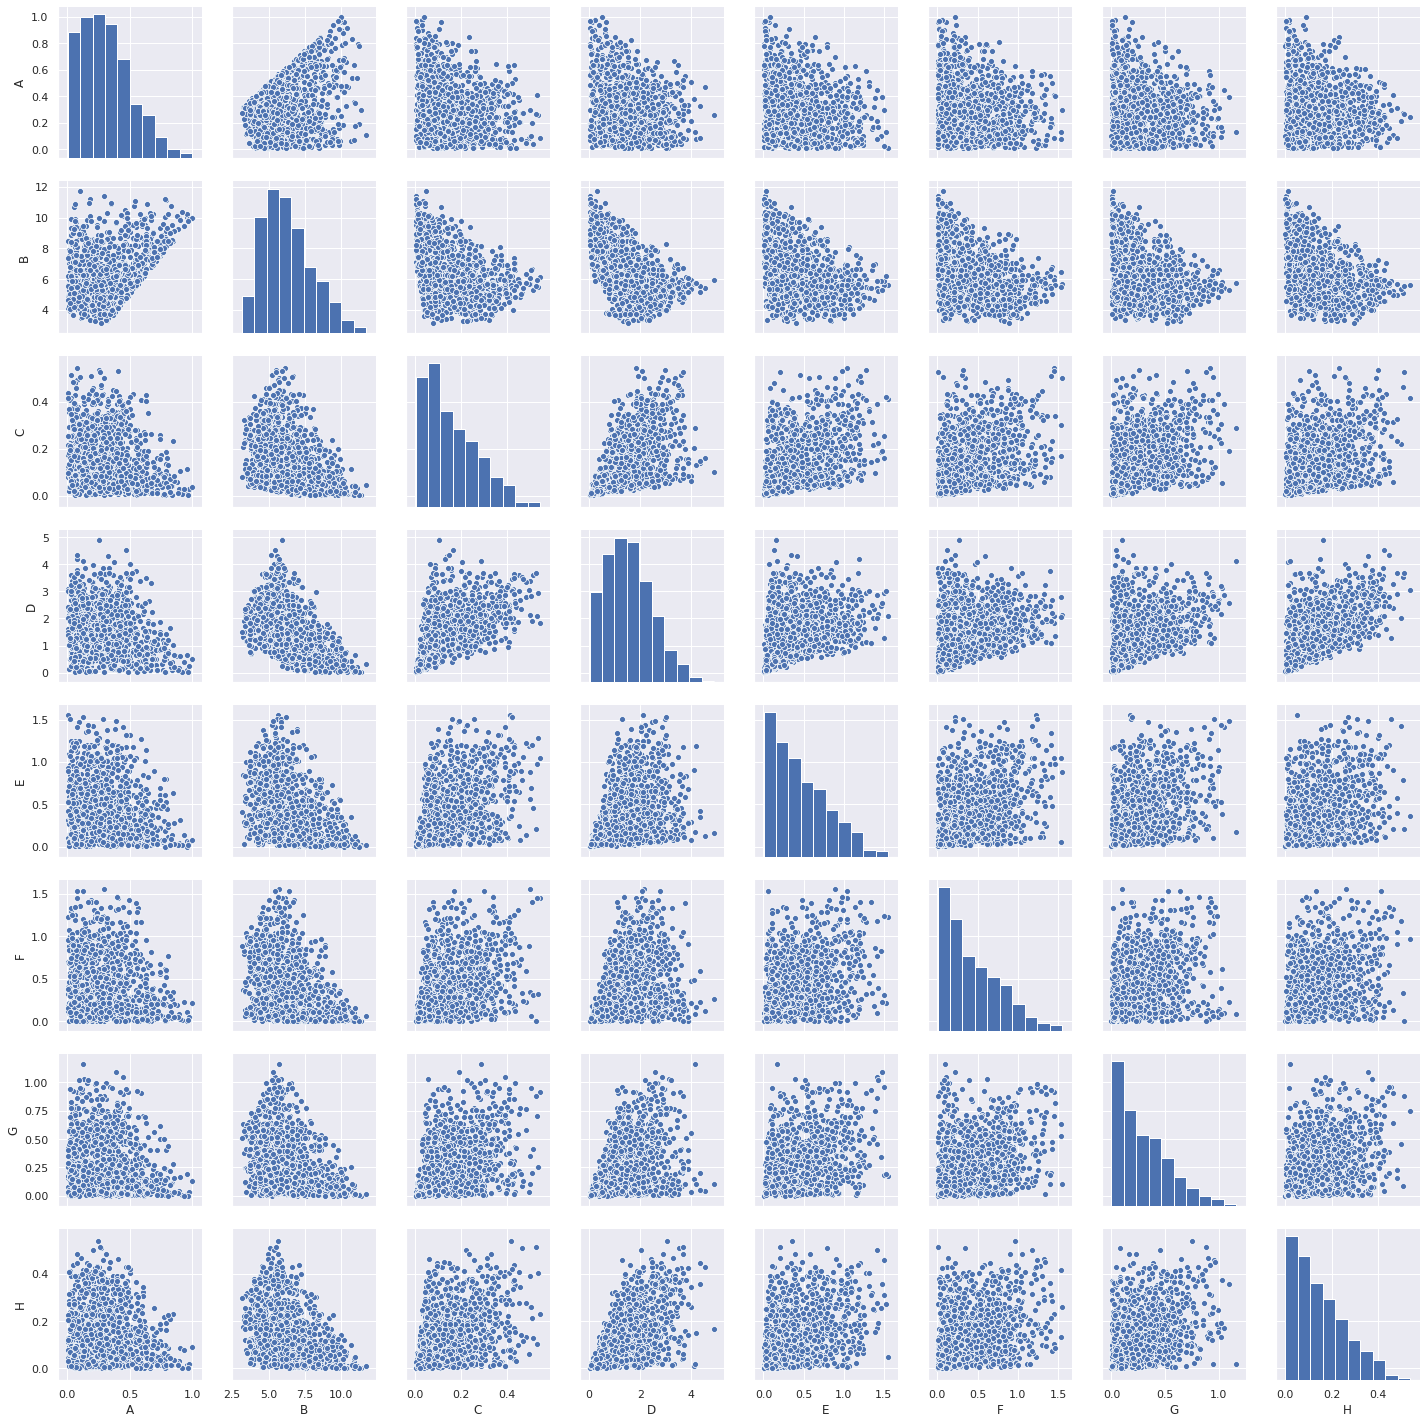

In [189]:
# Plot the initial compositions on a pairplot
sns.set_style("dark")
sns.set(rc={'figure.figsize':(16,20)})
sns.pairplot( input_space[input_compos] )
plt.show()

One can observe a non-uniform covering of the input space for the training dataset. and sometime clear cut in this input space sampling. 

This is because ratio of different quantities where used to determine boundaries in the sampling of the input parameter space. This was based on physical consideration and it was realised afterwards that it maybe wasn't the cleverest way to sample the data...  

## Normalization of the data

It is important to note that the composition data that make up the database are very heterogeneous. Indeed, the isotopes present in this database have typical compositions that can present orders of magnitude of differences . This can pose serious problems of standardization to succeed in learning the data at best. 

Let us for instance plot the distributions of the isotopes that makes up the input parameter space (i.e. isotopes A to H) at the initial T=0 and final T=1825 times : 

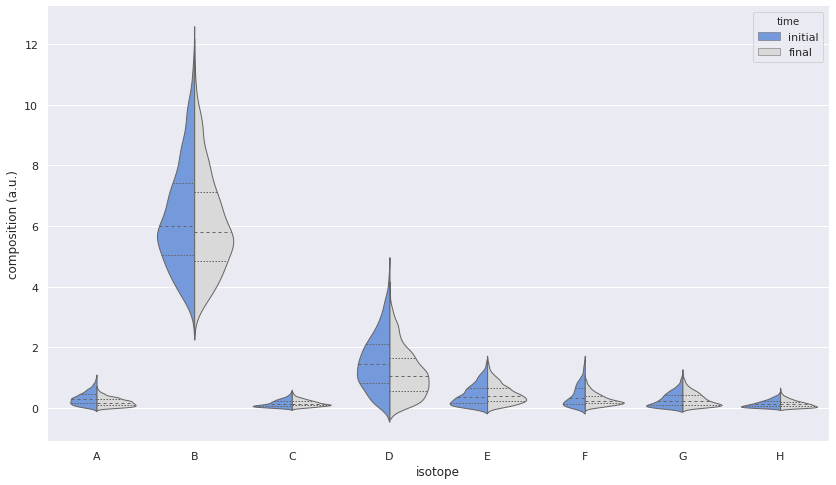

In [11]:
temp = pd.DataFrame()
for i in input_compos:
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain[i].loc[0] , "isotope":[i for j in dtrain[i].loc[0]] , "time":["initial" for j in dtrain[i].loc[0]]} ) )
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain[i].loc[80] , "isotope":[i for j in dtrain[i].loc[80]] , "time":["final" for j in dtrain[i].loc[80]]} ) )

## plot a violin plot for both the initial and final compositions of the input_compos  
sns.set(rc={'figure.figsize':(14,8)})
sns.violinplot(data=temp,x="isotope",y="composition (a.u.)",hue="time",split=True, inner="quartile", linewidth=1
               , palette={"initial":"cornflowerblue","final":".85"})
sns.despine(left=True)


As can be seen from the figure, most matter inside the reactor is made up of isotope B. 

The difficulty lies in the fact that we want, in the end, to have a precise __relative__ error on each individual isotope because it can happen that an isotope which is present in small quantities still has a non-negligible impact on the safety of the reactor and on the mitigation of an accident.

So we can't just be good in the absolute overall composition of the matter : we need to be sufficiently precise for each individual isotope !



The differences between the isotopes for the final compositions, adding all of the 26 isotopes, is even more flagrant :  

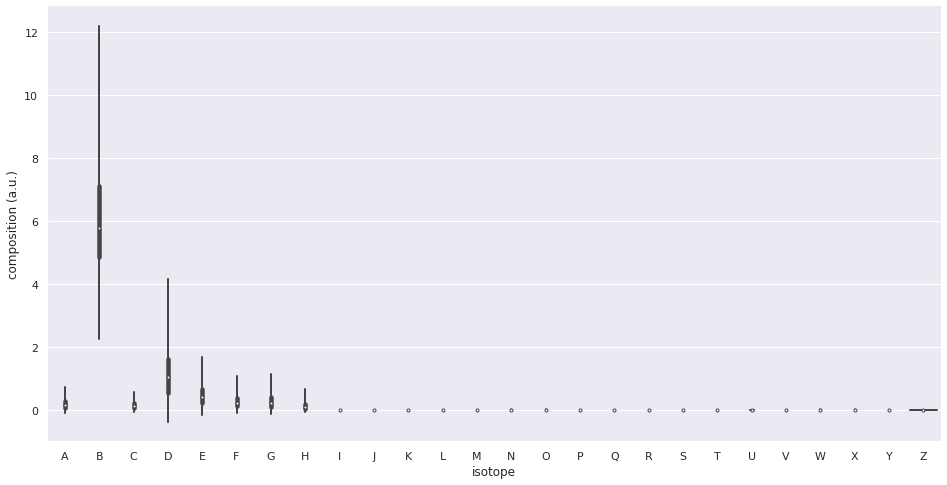

In [12]:
temp = pd.DataFrame()

for i in alphabet:
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain[i].loc[80] , 
                                     "isotope":[i for j in dtrain[i].loc[80]] , 
                                     "time":["final" for j in dtrain[i].loc[80]]} ) )
  
sns.set(rc={'figure.figsize':(16,8)})
sns.violinplot(data=temp,x="isotope",y="composition (a.u.)", inner="box")
sns.despine(left=True)

There, we want to be sufficiently precise on each individual isotopes, even if there exist ~ up to 5 orders of magnitudes between some isotopes ! 

In [13]:
dtrain.B.max(), dtrain.Z.max()

(11.71932, 0.0006211064)

A clever normalization of the input and output data is of paramount importance. 
In this notebook, we will simply use the most straightforward normalization possible : we will divide each composition by the maximum found for each isotope :

In [16]:
max_train_data = dtrain.max()
dtrain_norm = dtrain/max_train_data


max_test_data = dtest.max()
dtest_norm = dtest/max_test_data

It makes things a bit better 

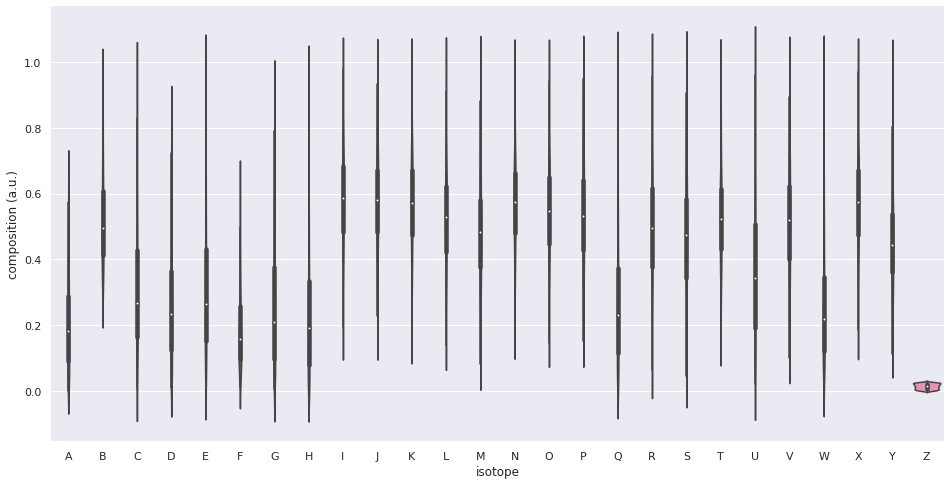

In [17]:
temp = pd.DataFrame()

for i in alphabet:
    temp=temp.append( pd.DataFrame( {"composition (a.u.)":dtrain_norm[i].loc[80] , 
                                     "isotope":[i for j in dtrain_norm[i].loc[80]] , 
                                     "time":["final" for j in dtrain_norm[i].loc[80]]} ) )
  
sns.set_style("dark")
sns.set(rc={'figure.figsize':(16,8)})
sns.violinplot(data=temp,x="isotope",y="composition (a.u.)", inner="box")
sns.despine(left=True)

It partially solves the problem, except for isotope Z which remains small as compared to the others...

## A simple baseline algorithm

A simple baseline model is now built. We will use a standard neural network built from the keras library. 

To treat time, we choose simply to treat this parameter has an input variable that will be fed to the neural network.


Our goal is to predict the composition of matter inside the reactor **at any given time** by just using its initial composition (isotopes A --> H) and the parameters p1, ..., p5.

To makes thing a bit more simple, we transform first our training and testing datasets, to prepare the use of the network where time is an input parameter.

In [42]:
train_data = pd.DataFrame()

for simu in range(0,920): # loop over each and every simulations (the 920 train data points)
    a = dtrain_norm.iloc[simu*81:(simu+1)*81]  # slice training dataset (the normalised dataset)
    b = a[input_params].iloc[0].to_dict()      # get T=0 data (the input data)
    for i in range(1,len(timesteps) ):         # loop over timesteps (from T=20 days to T=1825 days)
        c = a[alphabet + ["times"]]            # get target data ( compos A --> Z at current timestep + time)
        c.columns = ["target_"+i for i in alphabet] + ["times"]  
        c = c.iloc[i].to_dict()
        
        b.update(c)                            # merge dictionaries having input and output data 
        
        train_data = train_data.append( b , ignore_index=True)  # append current data (input + ouput) into a new dataset 

The training dataset looks now like this : 

In [43]:
train_data

,A,B,C,D,E,F,G,H,p1,p2,...,target_R,target_S,target_T,target_U,target_V,target_W,target_X,target_Y,target_Z,times
0,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.001006,0.023907,0.014016,0.000437,0.007372,0.000113,0.004920,0.011614,0.583623,0.010959
1,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.004260,0.048828,0.028339,0.001654,0.016239,0.000454,0.016625,0.023202,0.780646,0.021918
2,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.009417,0.072550,0.042912,0.003518,0.025447,0.001022,0.030789,0.034757,0.847143,0.032877
3,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.016173,0.095158,0.057661,0.005916,0.035010,0.001810,0.045801,0.046279,0.869604,0.043836
4,0.173969,0.360036,0.163230,0.446271,0.435704,0.051553,0.046750,0.257384,0.968901,0.600120,...,0.024234,0.116714,0.072580,0.008752,0.044900,0.002816,0.061083,0.057766,0.877192,0.054795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73595,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.493865,0.537330,0.572851,0.263394,0.519397,0.219291,0.562456,0.406605,0.709909,0.931507
73596,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.505905,0.541359,0.582078,0.266031,0.532221,0.227657,0.573223,0.414635,0.709830,0.942466
73597,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.518015,0.545169,0.591507,0.268760,0.544809,0.236167,0.583954,0.422652,0.709737,0.953425
73598,0.216568,0.586937,0.249847,0.267245,0.397406,0.498443,0.230448,0.383898,0.139166,0.459242,...,0.530126,0.548888,0.601001,0.271674,0.557177,0.244848,0.594652,0.430658,0.709657,0.964384


We do the same for the test dataset

In [58]:
test_data = pd.DataFrame()

for simu in range(0,200): # loop over each and every simulations (the 920 train data points)
    a = dtest_norm.iloc[simu*81:(simu+1)*81]  # slice training dataset (the normalised dataset)
    b = a[input_params].iloc[0].to_dict()      # get T=0 data (the input data)
    for i in range(1,len(timesteps) ):         # loop over timesteps (from T=20 days to T=1825 days)
        c = a[alphabet + ["times"]]            # get target data ( compos A --> Z at current timestep + time)
        c.columns = ["target_"+i for i in alphabet] + ["times"]  
        c = c.iloc[i].to_dict()
        
        b.update(c)                            # merge dictionaries having input and output data 
        
        test_data = test_data.append( b , ignore_index=True)  # append current data (input + ouput) into a new dataset 


In [59]:
test_data

,A,B,C,D,E,F,G,H,p1,p2,...,target_R,target_S,target_T,target_U,target_V,target_W,target_X,target_Y,target_Z,times
0,0.071712,0.755076,0.396549,0.227612,0.476123,0.306257,0.026057,0.401825,0.758357,0.553752,...,0.000752,0.020947,0.012396,0.000396,0.006792,0.000052,0.004284,0.009150,0.473310,0.010959
1,0.071712,0.755076,0.396549,0.227612,0.476123,0.306257,0.026057,0.401825,0.758357,0.553752,...,0.003201,0.042942,0.024998,0.001505,0.014947,0.000214,0.014480,0.018287,0.632993,0.021918
2,0.071712,0.755076,0.396549,0.227612,0.476123,0.306257,0.026057,0.401825,0.758357,0.553752,...,0.007104,0.064027,0.037756,0.003223,0.023412,0.000490,0.026825,0.027413,0.686821,0.032877
3,0.071712,0.755076,0.396549,0.227612,0.476123,0.306257,0.026057,0.401825,0.758357,0.553752,...,0.012217,0.084248,0.050674,0.005456,0.032155,0.000879,0.039916,0.036523,0.704932,0.043836
4,0.071712,0.755076,0.396549,0.227612,0.476123,0.306257,0.026057,0.401825,0.758357,0.553752,...,0.018334,0.103642,0.063707,0.008120,0.041195,0.001386,0.053250,0.045617,0.710968,0.054795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.785610,0.921594,0.107132,0.058454,0.176939,0.146471,0.081560,0.070836,0.991068,0.594849,...,0.775450,0.276597,0.546292,0.167205,0.816536,0.553706,0.869036,0.926351,0.359888,0.931507
15996,0.785610,0.921594,0.107132,0.058454,0.176939,0.146471,0.081560,0.070836,0.991068,0.594849,...,0.780440,0.276699,0.548045,0.169000,0.821062,0.559022,0.873576,0.931350,0.359850,0.942466
15997,0.785610,0.921594,0.107132,0.058454,0.176939,0.146471,0.081560,0.070836,0.991068,0.594849,...,0.785490,0.276785,0.549604,0.170646,0.825803,0.564366,0.878087,0.936333,0.359771,0.953425
15998,0.785610,0.921594,0.107132,0.058454,0.176939,0.146471,0.081560,0.070836,0.991068,0.594849,...,0.790535,0.276757,0.551269,0.172331,0.830299,0.569634,0.882576,0.941298,0.359692,0.964384


Build a basic neural network architecture ( 13 input parameters + time)

In [65]:
# Build simple MLP 

model = models.Sequential()
model.add( layers.Dense(100,activation='relu', input_shape= (train_data[input_params + ["times"]].shape[1],))  )
model.add( layers.Dense(100,activation='relu'))
model.add( layers.Dense(100,activation='relu'))
model.add( layers.Dense(50,activation='relu'))
model.add( layers.Dense(26) )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_23 (Dense)             (None, 26)                1326      
Total params: 28,076
Trainable params: 28,076
Non-trainable params: 0
_________________________________________________________________


To train the surrogate model, We used MSE and MAE as loss and validation respectively. A more refined choice might be necessary ... 

In [66]:
model.compile( optimizer=Adagrad() , loss="mse", metrics=["mae"])  # loss : either mse or logcosh

history = model.fit( train_data[input_params + ["times"]] , train_data[["target_"+i for i in alphabet]] , 
                    epochs=500, batch_size=20, validation_split=0.3,shuffle=True) 


Train on 51520 samples, validate on 22080 samples
Epoch 1/500
51520/51520 [==============================] - 3s 63us/step - loss: 0.0043 - mean_absolute_error: 0.0386 - val_loss: 0.0026 - val_mean_absolute_error: 0.0282
Epoch 2/500
51520/51520 [==============================] - 3s 57us/step - loss: 0.0022 - mean_absolute_error: 0.0247 - val_loss: 0.0020 - val_mean_absolute_error: 0.0234
Epoch 3/500
51520/51520 [==============================] - 3s 57us/step - loss: 0.0018 - mean_absolute_error: 0.0216 - val_loss: 0.0017 - val_mean_absolute_error: 0.0210
Epoch 4/500
51520/51520 [==============================] - 3s 57us/step - loss: 0.0016 - mean_absolute_error: 0.0198 - val_loss: 0.0015 - val_mean_absolute_error: 0.0194
Epoch 5/500
51520/51520 [==============================] - 3s 56us/step - loss: 0.0014 - mean_absolute_error: 0.0186 - val_loss: 0.0013 - val_mean_absolute_error: 0.0185
Epoch 6/500
51520/51520 [==============================] - 3s 57us/step - loss: 0.0013 - mean_absolu

Epoch 47/500
51520/51520 [==============================] - 3s 57us/step - loss: 4.7004e-04 - mean_absolute_error: 0.0101 - val_loss: 4.8194e-04 - val_mean_absolute_error: 0.0108
Epoch 48/500
51520/51520 [==============================] - 3s 57us/step - loss: 4.6387e-04 - mean_absolute_error: 0.0100 - val_loss: 4.5261e-04 - val_mean_absolute_error: 0.0103
Epoch 49/500
51520/51520 [==============================] - 3s 57us/step - loss: 4.5788e-04 - mean_absolute_error: 0.0100 - val_loss: 4.7830e-04 - val_mean_absolute_error: 0.0107
Epoch 50/500
51520/51520 [==============================] - 3s 57us/step - loss: 4.4825e-04 - mean_absolute_error: 0.0099 - val_loss: 4.7014e-04 - val_mean_absolute_error: 0.0104
Epoch 51/500
51520/51520 [==============================] - 3s 57us/step - loss: 4.4162e-04 - mean_absolute_error: 0.0099 - val_loss: 4.3214e-04 - val_mean_absolute_error: 0.0101
Epoch 52/500
51520/51520 [==============================] - 3s 57us/step - loss: 4.3589e-04 - mean_absolu

Epoch 93/500
51520/51520 [==============================] - 3s 57us/step - loss: 2.5768e-04 - mean_absolute_error: 0.0083 - val_loss: 3.6794e-04 - val_mean_absolute_error: 0.0102
Epoch 94/500
51520/51520 [==============================] - 3s 57us/step - loss: 2.5646e-04 - mean_absolute_error: 0.0083 - val_loss: 2.7099e-04 - val_mean_absolute_error: 0.0088
Epoch 95/500
51520/51520 [==============================] - 3s 57us/step - loss: 2.5178e-04 - mean_absolute_error: 0.0082 - val_loss: 2.5647e-04 - val_mean_absolute_error: 0.0084
Epoch 96/500
51520/51520 [==============================] - 3s 57us/step - loss: 2.5152e-04 - mean_absolute_error: 0.0082 - val_loss: 2.5852e-04 - val_mean_absolute_error: 0.0085
Epoch 97/500
51520/51520 [==============================] - 3s 57us/step - loss: 2.4709e-04 - mean_absolute_error: 0.0082 - val_loss: 3.3406e-04 - val_mean_absolute_error: 0.0095
Epoch 98/500
51520/51520 [==============================] - 3s 57us/step - loss: 2.4626e-04 - mean_absolu

51520/51520 [==============================] - 3s 58us/step - loss: 1.8475e-04 - mean_absolute_error: 0.0075 - val_loss: 1.9844e-04 - val_mean_absolute_error: 0.0079
Epoch 139/500
51520/51520 [==============================] - 3s 58us/step - loss: 1.8379e-04 - mean_absolute_error: 0.0075 - val_loss: 1.8782e-04 - val_mean_absolute_error: 0.0077
Epoch 140/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.8239e-04 - mean_absolute_error: 0.0075 - val_loss: 1.9270e-04 - val_mean_absolute_error: 0.0078
Epoch 141/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.8055e-04 - mean_absolute_error: 0.0074 - val_loss: 1.8493e-04 - val_mean_absolute_error: 0.0077
Epoch 142/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.8001e-04 - mean_absolute_error: 0.0074 - val_loss: 1.8276e-04 - val_mean_absolute_error: 0.0076
Epoch 143/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.7953e-04 - mean_absolute_error

51520/51520 [==============================] - 5s 95us/step - loss: 1.4899e-04 - mean_absolute_error: 0.0070 - val_loss: 1.6170e-04 - val_mean_absolute_error: 0.0075
Epoch 184/500
51520/51520 [==============================] - 5s 100us/step - loss: 1.4886e-04 - mean_absolute_error: 0.0070 - val_loss: 1.6715e-04 - val_mean_absolute_error: 0.0075
Epoch 185/500
51520/51520 [==============================] - 5s 103us/step - loss: 1.4795e-04 - mean_absolute_error: 0.0070 - val_loss: 1.5083e-04 - val_mean_absolute_error: 0.0072
Epoch 186/500
51520/51520 [==============================] - 5s 99us/step - loss: 1.4763e-04 - mean_absolute_error: 0.0070 - val_loss: 1.5517e-04 - val_mean_absolute_error: 0.0073
Epoch 187/500
51520/51520 [==============================] - 5s 94us/step - loss: 1.4747e-04 - mean_absolute_error: 0.0070 - val_loss: 1.4937e-04 - val_mean_absolute_error: 0.0072
Epoch 188/500
51520/51520 [==============================] - 5s 96us/step - loss: 1.4713e-04 - mean_absolute_err

51520/51520 [==============================] - 3s 59us/step - loss: 1.2881e-04 - mean_absolute_error: 0.0067 - val_loss: 1.3514e-04 - val_mean_absolute_error: 0.0069
Epoch 229/500
51520/51520 [==============================] - 3s 58us/step - loss: 1.2870e-04 - mean_absolute_error: 0.0067 - val_loss: 1.3773e-04 - val_mean_absolute_error: 0.0071
Epoch 230/500
51520/51520 [==============================] - 3s 58us/step - loss: 1.2765e-04 - mean_absolute_error: 0.0067 - val_loss: 1.3567e-04 - val_mean_absolute_error: 0.0070
Epoch 231/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.2755e-04 - mean_absolute_error: 0.0067 - val_loss: 1.4520e-04 - val_mean_absolute_error: 0.0072
Epoch 232/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.2674e-04 - mean_absolute_error: 0.0067 - val_loss: 1.6116e-04 - val_mean_absolute_error: 0.0075
Epoch 233/500
51520/51520 [==============================] - 3s 58us/step - loss: 1.2712e-04 - mean_absolute_error

51520/51520 [==============================] - 3s 57us/step - loss: 1.1483e-04 - mean_absolute_error: 0.0065 - val_loss: 1.2277e-04 - val_mean_absolute_error: 0.0067
Epoch 274/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.1462e-04 - mean_absolute_error: 0.0065 - val_loss: 1.3025e-04 - val_mean_absolute_error: 0.0069
Epoch 275/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.1438e-04 - mean_absolute_error: 0.0065 - val_loss: 1.2216e-04 - val_mean_absolute_error: 0.0068
Epoch 276/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.1399e-04 - mean_absolute_error: 0.0065 - val_loss: 1.1998e-04 - val_mean_absolute_error: 0.0067
Epoch 277/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.1345e-04 - mean_absolute_error: 0.0064 - val_loss: 1.2559e-04 - val_mean_absolute_error: 0.0068
Epoch 278/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.1342e-04 - mean_absolute_error

51520/51520 [==============================] - 3s 57us/step - loss: 1.0490e-04 - mean_absolute_error: 0.0063 - val_loss: 1.1234e-04 - val_mean_absolute_error: 0.0065
Epoch 319/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.0474e-04 - mean_absolute_error: 0.0063 - val_loss: 1.1179e-04 - val_mean_absolute_error: 0.0065
Epoch 320/500
51520/51520 [==============================] - 3s 56us/step - loss: 1.0428e-04 - mean_absolute_error: 0.0063 - val_loss: 1.1756e-04 - val_mean_absolute_error: 0.0067
Epoch 321/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.0430e-04 - mean_absolute_error: 0.0063 - val_loss: 1.2128e-04 - val_mean_absolute_error: 0.0068
Epoch 322/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.0394e-04 - mean_absolute_error: 0.0063 - val_loss: 1.1663e-04 - val_mean_absolute_error: 0.0067
Epoch 323/500
51520/51520 [==============================] - 3s 57us/step - loss: 1.0402e-04 - mean_absolute_error

51520/51520 [==============================] - 3s 57us/step - loss: 9.7988e-05 - mean_absolute_error: 0.0061 - val_loss: 1.0770e-04 - val_mean_absolute_error: 0.0064
Epoch 364/500
51520/51520 [==============================] - 3s 56us/step - loss: 9.7879e-05 - mean_absolute_error: 0.0061 - val_loss: 1.2027e-04 - val_mean_absolute_error: 0.0067
Epoch 365/500
51520/51520 [==============================] - 3s 57us/step - loss: 9.7395e-05 - mean_absolute_error: 0.0061 - val_loss: 1.0638e-04 - val_mean_absolute_error: 0.0064
Epoch 366/500
51520/51520 [==============================] - 3s 56us/step - loss: 9.7386e-05 - mean_absolute_error: 0.0061 - val_loss: 1.1202e-04 - val_mean_absolute_error: 0.0065
Epoch 367/500
51520/51520 [==============================] - 3s 57us/step - loss: 9.7294e-05 - mean_absolute_error: 0.0061 - val_loss: 1.0658e-04 - val_mean_absolute_error: 0.0065
Epoch 368/500
51520/51520 [==============================] - 3s 56us/step - loss: 9.7342e-05 - mean_absolute_error

51520/51520 [==============================] - 3s 56us/step - loss: 9.2543e-05 - mean_absolute_error: 0.0060 - val_loss: 9.9933e-05 - val_mean_absolute_error: 0.0063
Epoch 409/500
51520/51520 [==============================] - 3s 56us/step - loss: 9.2351e-05 - mean_absolute_error: 0.0060 - val_loss: 1.0039e-04 - val_mean_absolute_error: 0.0064
Epoch 410/500
51520/51520 [==============================] - 3s 57us/step - loss: 9.1832e-05 - mean_absolute_error: 0.0060 - val_loss: 1.0127e-04 - val_mean_absolute_error: 0.0063
Epoch 411/500
51520/51520 [==============================] - 3s 56us/step - loss: 9.2068e-05 - mean_absolute_error: 0.0060 - val_loss: 1.0558e-04 - val_mean_absolute_error: 0.0064
Epoch 412/500
51520/51520 [==============================] - 3s 56us/step - loss: 9.1890e-05 - mean_absolute_error: 0.0060 - val_loss: 1.0136e-04 - val_mean_absolute_error: 0.0063
Epoch 413/500
51520/51520 [==============================] - 3s 56us/step - loss: 9.2051e-05 - mean_absolute_error

51520/51520 [==============================] - 3s 57us/step - loss: 8.7791e-05 - mean_absolute_error: 0.0059 - val_loss: 9.5166e-05 - val_mean_absolute_error: 0.0061
Epoch 454/500
51520/51520 [==============================] - 3s 56us/step - loss: 8.7558e-05 - mean_absolute_error: 0.0059 - val_loss: 9.9010e-05 - val_mean_absolute_error: 0.0063
Epoch 455/500
51520/51520 [==============================] - 3s 56us/step - loss: 8.7536e-05 - mean_absolute_error: 0.0059 - val_loss: 9.4976e-05 - val_mean_absolute_error: 0.0061
Epoch 456/500
51520/51520 [==============================] - 3s 57us/step - loss: 8.7350e-05 - mean_absolute_error: 0.0059 - val_loss: 1.0331e-04 - val_mean_absolute_error: 0.0063
Epoch 457/500
51520/51520 [==============================] - 3s 57us/step - loss: 8.7764e-05 - mean_absolute_error: 0.0059 - val_loss: 9.5014e-05 - val_mean_absolute_error: 0.0062
Epoch 458/500
51520/51520 [==============================] - 3s 57us/step - loss: 8.7316e-05 - mean_absolute_error

51520/51520 [==============================] - 3s 57us/step - loss: 8.3955e-05 - mean_absolute_error: 0.0058 - val_loss: 9.1934e-05 - val_mean_absolute_error: 0.0061
Epoch 499/500
51520/51520 [==============================] - 3s 57us/step - loss: 8.3925e-05 - mean_absolute_error: 0.0058 - val_loss: 9.2952e-05 - val_mean_absolute_error: 0.0061
Epoch 500/500
51520/51520 [==============================] - 3s 57us/step - loss: 8.3317e-05 - mean_absolute_error: 0.0058 - val_loss: 9.4821e-05 - val_mean_absolute_error: 0.0061


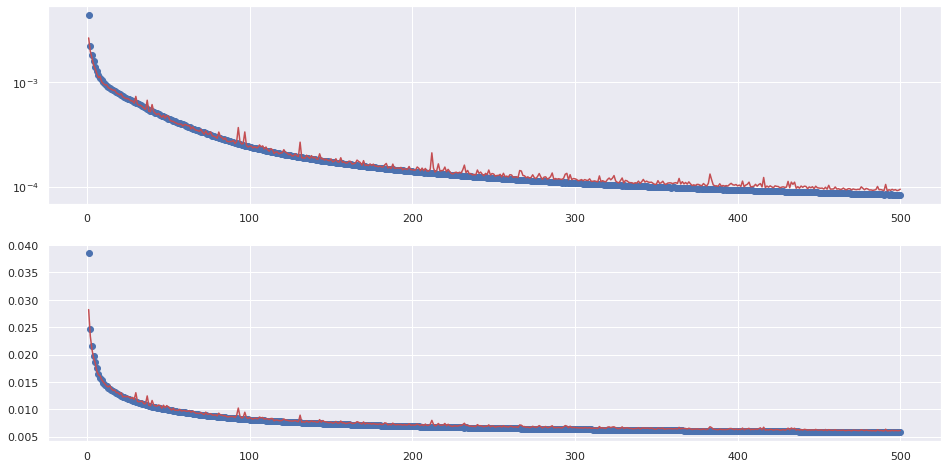

In [67]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1 , len(loss)+1)

plt.subplot( 2 , 1, 1 )
plt.plot(epochs , loss , "bo")
plt.plot(epochs , val_loss , "r")
plt.yscale("log")
plt.subplot( 2 , 1, 2 )
plt.plot(epochs , history.history["mean_absolute_error"] , "bo")
plt.plot(epochs , history.history["val_mean_absolute_error"]  , "r")

#plt.yscale("log")
plt.show()

In [68]:
# Use NN to predict the compos of test data 
res = model.predict( test_data[input_params + ["times"]]  )

for i,val in enumerate(alphabet):
    test_data["res_"+val] = res[:,i]

print( "Mean accuracy (%) :")

for i,name in enumerate(alphabet):
    test_data["diff_"+name] = (test_data["target_"+name]-test_data["res_"+name])/test_data["target_"+name]
    print(name, "  ",100-np.abs(test_data["diff_"+name].mean()*100))

Mean accuracy (%) :
A    98.69900042123233
B    99.95382167069158
C    99.55839877855556
D    98.97802490857569
E    98.37882908610509
F    99.94603528650586
G    99.89108250878817
H    94.04446325021966
I    57.85822218401288
J    89.03974853528157
K    88.3312460639647
L    89.6873758751826
M    97.40095218595721
N    88.98827957533761
O    92.64035436650636
P    50.667917184927035
Q    77.46441852219277
R    -519.4133997865536
S    91.83058122625
T    91.12312108110521
U    69.0409120841842
V    87.246831045526
W    -1060.1060634642558
X    80.97190045542567
Y    85.73620715001738
Z    92.4717119101787


The overall performances are almost perfect for some isotopes and very bad for others. We might want to investigate the problem in more depth :

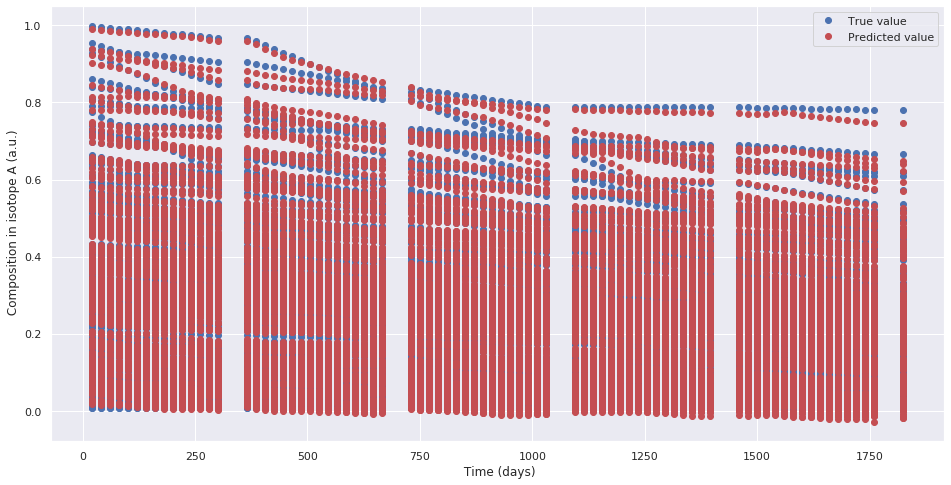

In [97]:
plt.plot( test_data["times"]*max_test_data.times, test_data["target_A"] ,"bo", label="True value" )
plt.plot( test_data["times"]*max_test_data.times, test_data["res_A"] ,"ro", label="Predicted value" )

plt.xlabel(" Time (days)")
plt.ylabel(" Composition in isotope A (a.u.)")
plt.legend()
plt.show()

Isotope A as a nice temporal behaviour, it is quite easy to get good results with this kind of isotope.

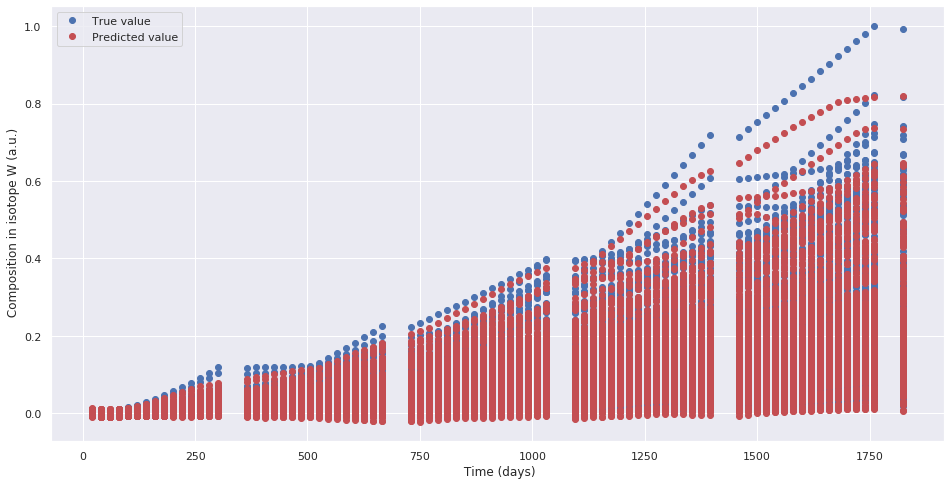

In [99]:
plt.plot( test_data["times"]*max_test_data.times, test_data["target_W"] ,"bo", label="True value" )
plt.plot( test_data["times"]*max_test_data.times, test_data["res_W"] ,"ro", label="Predicted value" )

plt.xlabel(" Time (days)")
plt.ylabel(" Composition in isotope W (a.u.)")
plt.legend()
plt.show()

the ovrall temporal behaviour of isotope W is also globally well reproduced, except for the most extreme bahviours, where certainly more data would have helped.

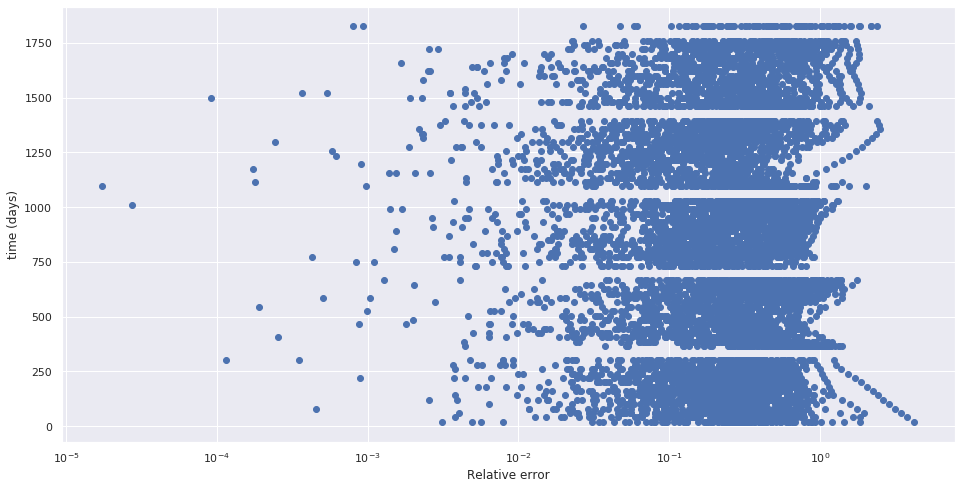

In [89]:
plt.plot( test_data["diff_B"]*100 , test_data["times"]*max_test_data['times'], "bo" )
plt.xscale('log')

plt.xlabel('Relative error')
plt.ylabel( 'time (days)' )
plt.show()

The relatives errors ( true - predicted)/true are very nice for isotope B, and stays constant with time

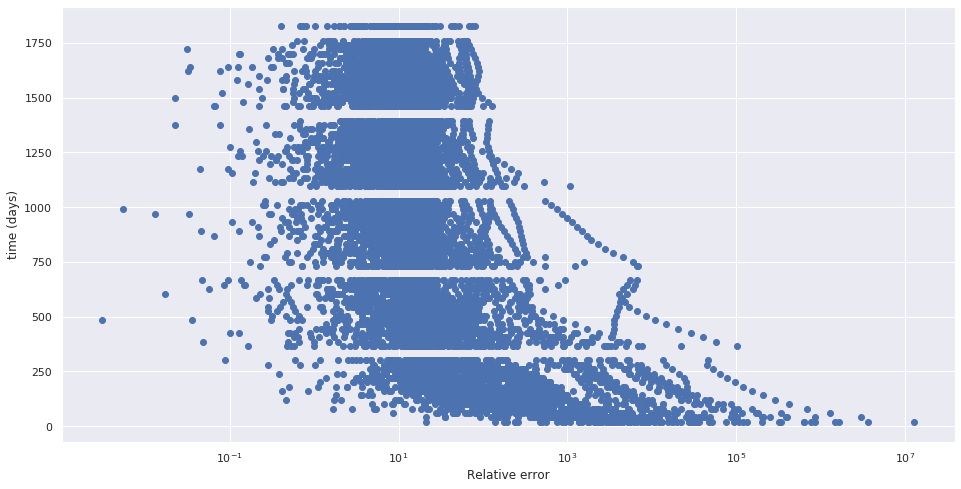

In [90]:
plt.plot( test_data["diff_W"]*100 , test_data["times"]*max_test_data['times'], "bo" )
plt.xscale('log')

plt.xlabel('Relative error')
plt.ylabel( 'time (days)' )
plt.show()

For more complex isotopes, like W, the error is very large at the beggining, because the initial composition is very low. It gets better at the end of irradiation but is still too large on overall...

Let us look at the dirstibutions of the true and predicted compositions for the final time (T = 1825 days) 

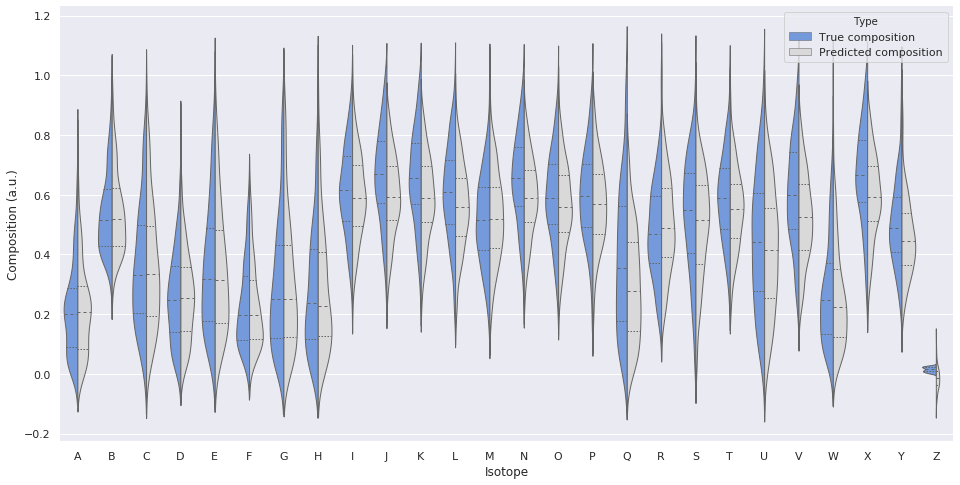

In [167]:
test_data_final = test_data[ test_data["times"]*max_test_data.times == 1825.0] 

d={}

d["Composition (a.u.)"] = []
d["Isotope"] = [ ]
d["Type"] = []


for i in alphabet: 
    
    
    d["Composition (a.u.)"] += test_data_final["target_"+i].to_list() + test_data_final["res_"+i].to_list()
    d["Isotope"] += [i]*400
    d["Type"] += ["True composition"]*200 + ["Predicted composition"]*200

temp = pd.DataFrame(d)

sns.set(rc={'figure.figsize':(16,8)})
sns.violinplot(data=temp,x="Isotope",y="Composition (a.u.)",hue="Type",
               split=True, inner="quartile", linewidth=1
               , palette={"True composition":"cornflowerblue","Predicted composition":".85"})
sns.despine(left=True)

To conclude, let us highlight some discrepancies that we believe is typical from the hard cuts that were performed in the input parameter space :

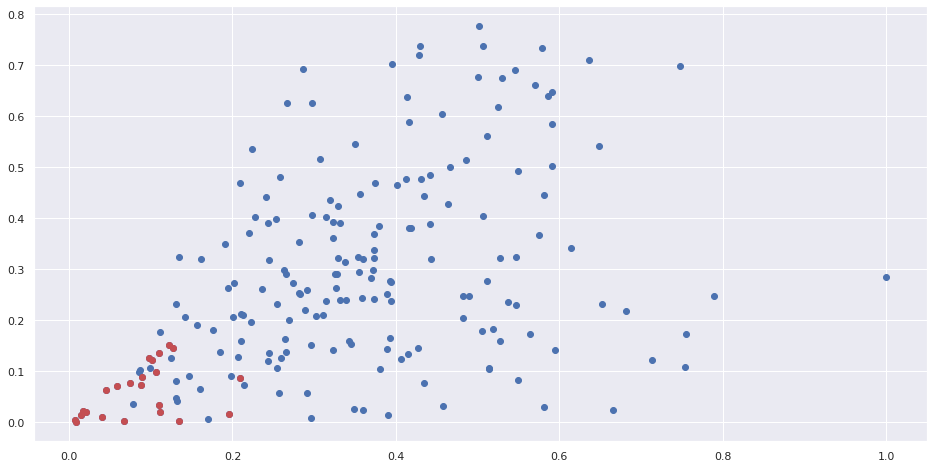

In [188]:
plt.plot( test_data_final["D"], test_data_final["H"], "bo")
plt.plot( test_data_final[np.fabs(test_data_final["diff_H"]) > 0.25]["D"], 
         test_data_final[np.fabs(test_data_final["diff_H"]) > 0.25]["H"], "ro")

plt.show()

The points in blue on the figure are the initial compositions of the test points in the input parameter space D vs H.

In red, the same test points are highlighted only if the error of the prediction at T=1825 days is greater than 25%. All of the points with large errors are located in the corner of the distribution... 
